# RNN 및 CNN 모델을 활용한 영화리뷰 텍스트 감성분석하기 

## 학습 목표
- 텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환하는 과정을 이해한다.
- RNN의 특징을 이해하고 시퀀셜한 데이터를 다루는 방법을 이해한다.
- 1-D CNN으로도 텍스트를 처리할 수 있음을 이해한다.
- IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성 분류 실습을 진행한다.

 ### 용어 정리
 
- 워드 임베딩(word embedding) 기법 : 감성분석의 비용을 절감하면서 정확도를 크게 향상시킬 수 있는 자연어처리 기법(단어의 특성을 저차원 벡터값으로 표현함)
- join () : 모든 반복 자료형의 데이터를 하나의 문자열로 합치는 기능을 수행함.
- ed_sentence ; 인덱싱된 것을 매핑된 것으로 확인 가능함.
ex) eat 이 6번으로 인덱싱되면,그것을 확인하는 것을 매핑이라고 이야기함.
- vocab_size : 어휘 사전의 크기(사전 안의 단어개수를 표현)
- tokenizer : 보통 공백, 구두점, 특수문자 등으로 text를 여러개의 token으로 나누는 함수.
- token : 문법적으로 더 이상 나눌 수 없는 언어요소를 뜻
- decode() : 수치데이터에서 다시 원래 데이터로 복구 시키는 것.
- word_vector_dim : 단어 하나를 표현하는 임베딩 벡터의 차원 수
- GlobalMaxPooling1D() 레이어  : 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식
- imdb.load_data() 호출 시 단어사전에 등재할 단어의 개수(num_words)를 10000으로 지정하면, 그 개수만큼의 word_to_index 딕셔너리까지 생성된 형태로 데이터셋이 생성됨.
- np.std() : 표준편차 구하기
- model.compile() : 학습과정 설정 ex) optimizer, loss(손실값), metrics(평가지표)
- weights = model.get_weights():모델의 시냅스 가중치 (weights)를 weights 변수에 저장하고 출력
- 텍스트를 숫자로 바꾸려면 위의 딕셔너리가 {텍스트:인덱스} 구조여야 하며, 단순히 인덱싱으로 끝내는 것이 아니라 단어의 의미를 나타내는 벡터를 짝지어 보기위해서 단어의 의미를 나타내는 벡터를 훈련가능한 파라미터로 놓고 이를 딥러닝을 통해 학습해서 최적화시킴

## 기타 알게된 지식
-  Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 함. raw_inputs의 3개 벡터의 길이 재확인 할 것 ,Tensorflow에서는tf.keras.preprocessing.sequence.pad_sequences라는 편리한 함수를 통해 문장 벡터 뒤에 패딩(<PAD>)을 추가하여 길이를 일정하게 맞춰주는 기능을 제공 
- maxlen : 패딩의 길이를 더 늘리고 싶거나, 단어의 나열 수가 너무 많아 길이를 짧게 하고 싶을 수 있는데, 이러한 경우 pad_sequences() 함수 안에 maxlen의 값을 입력해서 그 값을 지정해주면 됨. 따라서 max_len의 인자로 정수를 주면, 해당 정수로 모든 문서의 길이를 동일하게 해줌.    
- embedding을 통하여 input값을 output로 반환할 때 shape는 (입력문장 개수, 입력문장 최대길이, 워드 벡터의 차원수)를 나타냄
- RNN(Recurrent Neural Network(RNN) : 시퀀스(Sequence) 형태 -(Ex,음성인식)의 데이터를 처리하기에 최적인 모델로서, 시간의 흐름에 따라 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는 state machine(그전에 입력된 것을 기억)으로 설계되어 있음.
- 1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용됨. RNN보다 병렬처리가 효율적임.
- IMDb 데이터셋의 텍스트 인코딩을 위한 word_to_index, index_to_word사용시, 실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있음.따라서, word_to_index = {k:(v+3) for k,v in word_to_index.items()} 이렇게 보정해줘야됨.
- padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느 쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생함.- RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됨. 따라서 'pre'가 훨씬 유리함.

## 라이브러리 Import

In [1]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf

import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline


from konlpy.tag import Okt
from konlpy.tag import Mecab
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

## 데이터 준비와 확인

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

In [2]:
#연결이 잘 됬는지, 읽어와 봅시다!


# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data[:20]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


### 데이터셋 정보
- 특성은 id, document, label 총 3가지.
    - id : 리뷰 쓴 사람의 id를 숫자로 적어둔 것 같음
    - document : 리뷰 내용
    - label : target data, 리뷰에대한 라벨이 달려있음. (긍정 : 1, 부정 : 0)

- NSMC 데이터셋은 총 200K, 20만개, test데이터 5만개, train data 15만개로 이루어졌다.

- 20만개의 총 데이터 셋 중 긍정 리뷰와 부정 리뷰의 데이터 비율은 1:1.
- document의 글자수는 140자보다 작다.

## 데이터로더 구성

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 단어 사전에 등재할 단어 개수 10,000개 
    # drop_duplicates : 데이터의 중복 제거 , dropna : NaN 결측치 제거 
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    #사전word_to_index 구성 
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    #vocab에 0 = 패딩용 단어, 1 = 문장의 시작지점, 2 = 사전에 없는 단어 라벨링. 
    vocab = ['<PAD>', '<BOS>', '<UNK>','<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # word_to_index에 들어있는 단어가 아니라면 <UNK>를 붙여주세요 
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# 학습용, test용 데이터 나누기    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

# 텍스트 스트링을 사전 인덱스 스트링으로 변환
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시

## 모델 구성을 위한 데이터 분석 및 가공

In [6]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [7]:
get_decoded_sentence(X_train[0], index_to_word)

'더 빙 . . 진짜 짜증 나 네요 목소리'

In [8]:
X_train[0]

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [9]:
print('\'더\' 의 인덱스 번호 :',word_to_index['더'])
print('\'빙\' 의 인덱스 번호 :',word_to_index['빙'])
print('\'더빙\' 의 인덱스 번호 :',word_to_index['더빙'])

'더' 의 인덱스 번호 : 74
'빙' 의 인덱스 번호 : 919
'더빙' 의 인덱스 번호 : 982


#### 데이터셋 내 문장 길이 분포 확인 및 문장길이 지정

In [10]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


#### 문장 길이 조정하고, 패딩 설정하기

In [12]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
# 문장 길이와 패딩 적용하기 
# 모델 적용시, padding_where 변수로 앞쪽 - 'pre', 뒤쪽 - 'post' 을 결정할 수 있게. 
# 일단 default값으로 'pre' 
padding_where = 'pre'

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
       value=word_to_index["<PAD>"],padding=padding_where, maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
       value=word_to_index["<PAD>"],padding=padding_where, maxlen=maxlen)

## 모델 구성 

In [19]:
# RNN 모델 
# padding_where = 'pre'

rnn_vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
rnn_word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Embedding(rnn_vocab_size, rnn_word_vector_dim, input_shape=(None,)))
# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
rnn_model.add(tf.keras.layers.LSTM(8))   
rnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [20]:
# 1-D CNN 모델
# padding_where = 'post'

cnn1d_vocab_size = 10000  # 어휘 사전의 크기입니다
cnn1d_word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

cnn1d_model = tf.keras.Sequential()
cnn1d_model.add(tf.keras.layers.Embedding(cnn1d_vocab_size, cnn1d_word_vector_dim, input_shape=(None,)))
cnn1d_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn1d_model.add(tf.keras.layers.MaxPooling1D(5))
cnn1d_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn1d_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn1d_model.add(tf.keras.layers.Dense(8, activation='relu'))
cnn1d_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn1d_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [21]:
# GlobalMaxPooling1D 모델 / 대문자를 따서 gmp 라 칭하겠습니다 :) 
# padding_where = 'post'

gmp_vocab_size = 10000  # 어휘 사전의 크기입니다
gmp_word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

gmp_model = tf.keras.Sequential()
gmp_model.add(tf.keras.layers.Embedding(gmp_vocab_size, gmp_word_vector_dim, input_shape=(None,)))
gmp_model.add(tf.keras.layers.GlobalMaxPooling1D())
gmp_model.add(tf.keras.layers.Dense(8, activation='relu'))
gmp_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmp_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


##  validation set 구성

- Numpy 슬라이싱 기능을 이용해 데이터를 나눠줌
- 훈련 데이터 146,182 개 중, 49,157 개를 validation set으로 사용함.

In [16]:
# validation set 49157건 분리
X_val = X_train[:49157]   
y_val = y_train[:49157]

# validation set을 제외한 나머지 = train data 
partial_X_train = X_train[49157:]  
partial_y_train = y_train[49157:]

print('훈련용 데이터 : ', partial_X_train.shape)
print('훈련용 정답 데이터 : ', partial_y_train.shape)
print()
print('검증용 데이터 : ', X_val.shape)
print('검증용  정답 데이터 : ', y_val.shape)

훈련용 데이터 :  (97025, 41)
훈련용 정답 데이터 :  (97025,)

검증용 데이터 :  (49157, 41)
검증용  정답 데이터 :  (49157,)


In [17]:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## 모델 훈련 개시

In [22]:
# RNN 모델 훈련하기 
padding_where = 'pre'

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 20

rnn_history = rnn_model.fit(partial_X_train,partial_y_train,epochs=epochs,
                    batch_size=512,validation_data=(X_val, y_val),verbose=1)

Epoch 1/20
190/190 [==============================] - 14s 9ms/step - loss: 0.5704 - accuracy: 0.7289 - val_loss: 0.4330 - val_accuracy: 0.8359
Epoch 2/20
190/190 [==============================] - 1s 6ms/step - loss: 0.3732 - accuracy: 0.8499 - val_loss: 0.3585 - val_accuracy: 0.8464
Epoch 3/20
190/190 [==============================] - 1s 6ms/step - loss: 0.3236 - accuracy: 0.8671 - val_loss: 0.3526 - val_accuracy: 0.8496
Epoch 4/20
190/190 [==============================] - 1s 6ms/step - loss: 0.3047 - accuracy: 0.8761 - val_loss: 0.3512 - val_accuracy: 0.8507
Epoch 5/20
190/190 [==============================] - 1s 6ms/step - loss: 0.2912 - accuracy: 0.8827 - val_loss: 0.3554 - val_accuracy: 0.8477
Epoch 6/20
190/190 [==============================] - 1s 6ms/step - loss: 0.2795 - accuracy: 0.8876 - val_loss: 0.3597 - val_accuracy: 0.8482
Epoch 7/20
190/190 [==============================] - 1s 6ms/step - loss: 0.2688 - accuracy: 0.8918 - val_loss: 0.3664 - val_accuracy: 0.8489
Epoch

In [23]:
# 1-D CNN 모델 훈련하기 
padding_where = 'post'

cnn1d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 20

cnn1d_history = cnn1d_model.fit(partial_X_train,partial_y_train,epochs=epochs,
                    batch_size=512,validation_data=(X_val, y_val),verbose=1)

Epoch 1/20
190/190 [==============================] - 12s 8ms/step - loss: 0.5684 - accuracy: 0.6851 - val_loss: 0.3834 - val_accuracy: 0.8308
Epoch 2/20
190/190 [==============================] - 1s 5ms/step - loss: 0.3481 - accuracy: 0.8512 - val_loss: 0.3484 - val_accuracy: 0.8476
Epoch 3/20
190/190 [==============================] - 1s 5ms/step - loss: 0.3098 - accuracy: 0.8707 - val_loss: 0.3451 - val_accuracy: 0.8501
Epoch 4/20
190/190 [==============================] - 1s 5ms/step - loss: 0.2847 - accuracy: 0.8834 - val_loss: 0.3466 - val_accuracy: 0.8507
Epoch 5/20
190/190 [==============================] - 1s 5ms/step - loss: 0.2613 - accuracy: 0.8951 - val_loss: 0.3517 - val_accuracy: 0.8513
Epoch 6/20
190/190 [==============================] - 1s 5ms/step - loss: 0.2371 - accuracy: 0.9065 - val_loss: 0.3631 - val_accuracy: 0.8499
Epoch 7/20
190/190 [==============================] - 1s 5ms/step - loss: 0.2128 - accuracy: 0.9186 - val_loss: 0.3853 - val_accuracy: 0.8460
Epoch

In [24]:
# GlobalMaxPooling1D 모델 훈련하기 
padding_where = 'post'

gmp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 20

gmp_history = gmp_model.fit(partial_X_train,partial_y_train,epochs=epochs,
                    batch_size=512,validation_data=(X_val, y_val),verbose=1)

Epoch 1/20
190/190 [==============================] - 1s 4ms/step - loss: 0.6344 - accuracy: 0.6600 - val_loss: 0.5173 - val_accuracy: 0.8033
Epoch 2/20
190/190 [==============================] - 1s 4ms/step - loss: 0.4229 - accuracy: 0.8287 - val_loss: 0.3788 - val_accuracy: 0.8352
Epoch 3/20
190/190 [==============================] - 1s 4ms/step - loss: 0.3417 - accuracy: 0.8559 - val_loss: 0.3596 - val_accuracy: 0.8419
Epoch 4/20
190/190 [==============================] - 1s 4ms/step - loss: 0.3076 - accuracy: 0.8735 - val_loss: 0.3561 - val_accuracy: 0.8447
Epoch 5/20
190/190 [==============================] - 1s 4ms/step - loss: 0.2835 - accuracy: 0.8847 - val_loss: 0.3592 - val_accuracy: 0.8449
Epoch 6/20
190/190 [==============================] - 1s 4ms/step - loss: 0.2642 - accuracy: 0.8936 - val_loss: 0.3653 - val_accuracy: 0.8449
Epoch 7/20
190/190 [==============================] - 1s 4ms/step - loss: 0.2477 - accuracy: 0.9013 - val_loss: 0.3738 - val_accuracy: 0.8433
Epoch 

## 모델 평가

In [25]:
print('-'*20)
print()
rnn_results = rnn_model.evaluate(X_test, y_test, verbose=2)
print('RNN 모델 결과 :', rnn_results)
print()

print('-'*20)
print()
cnn1d_results = cnn1d_model.evaluate(X_test, y_test, verbose=2)
print('cnn1d 모델 결과 :', cnn1d_results)
print()

print('-'*20)
print()
gmp_results = gmp_model.evaluate(X_test, y_test, verbose=2)
print('gmp 모델 결과 :', gmp_results)
print()

--------------------

1537/1537 - 3s - loss: 0.5462 - accuracy: 0.8318
RNN 모델 결과 : [0.5462064743041992, 0.8318042159080505]

--------------------

1537/1537 - 2s - loss: 0.9088 - accuracy: 0.8148
cnn1d 모델 결과 : [0.9088407754898071, 0.8147568106651306]

--------------------

1537/1537 - 2s - loss: 0.5604 - accuracy: 0.8204
gmp 모델 결과 : [0.5604209899902344, 0.8204324841499329]



## Loss, Accuracy 그래프 시각화

(1) RNN 모델 Loss, Accuracy 시각화

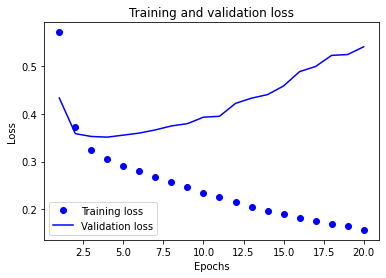

In [26]:
rnn_hidi = rnn_history.history

# Loss 그래프 시각화 
rnn_acc = rnn_hidi['accuracy']
rnn_val_acc = rnn_hidi['val_accuracy']
rnn_loss = rnn_hidi['loss']
rnn_val_loss = rnn_hidi['val_loss']

epochs = range(1, len(rnn_acc) + 1)

# 'bo' =  파란색 점 
plt.plot(epochs, rnn_loss, 'bo', label='Training loss')

#'b' = 파란 실선
plt.plot(epochs, rnn_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

RNN 모델 적용시 검증셋과 훈련셋의 Loss값의 차이가 큼을 확인함

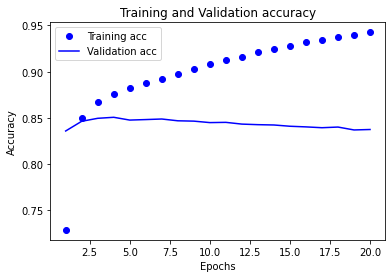

In [27]:
# Accuracy 그래프 시각화 

plt.clf() # 그림을 초기화 합니다.

plt.plot(epochs, rnn_acc, 'bo', label='Training acc')
plt.plot(epochs, rnn_val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

정확도 또한 훈련한 데이터의 값은 epochs가 증가함에 따라 증가하지만 검증셋은 변화가 없음

(2) 1-D CNN 모델 Loss, Accuracy 시각화

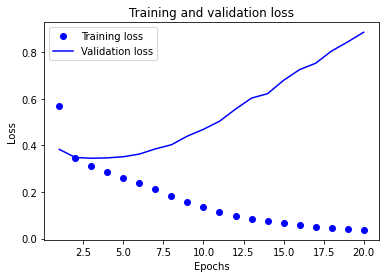

In [30]:
cnn_hidi = cnn1d_history.history

# Loss 그래프 시각화 
cnn_acc = cnn_hidi['accuracy']
cnn_val_acc = cnn_hidi['val_accuracy']
cnn_loss = cnn_hidi['loss']
cnn_val_loss = cnn_hidi['val_loss']

epochs = range(1, len(cnn_acc) + 1)

# 'bo' =  파란색 점 
plt.plot(epochs, cnn_loss, 'bo', label='Training loss')

#'b' = 파란 실선
plt.plot(epochs, cnn_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

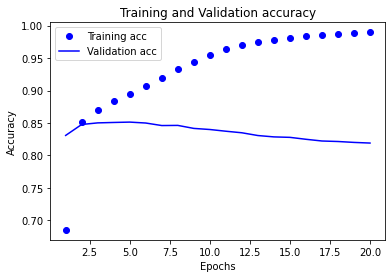

In [31]:
# Accuracy 그래프 시각화 

plt.clf() # 그림을 초기화 합니다.

plt.plot(epochs, cnn_acc, 'bo', label='Training acc')
plt.plot(epochs, cnn_val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

CNN model 또한 형편없음을 확인함

(3) GlobalMaxPooling1D 모델 Loss, Accuracy 시각화

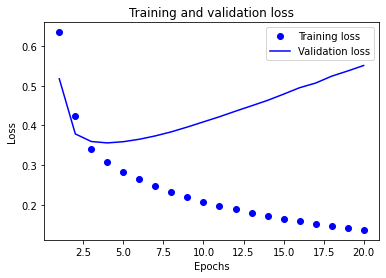

In [32]:
gmp_hidi = gmp_history.history

# Loss 그래프 시각화 
gmp_acc = gmp_hidi['accuracy']
gmp_val_acc = gmp_hidi['val_accuracy']
gmp_loss = gmp_hidi['loss']
gmp_val_loss = gmp_hidi['val_loss']

epochs = range(1, len(gmp_acc) + 1)

# 'bo' =  파란색 점 
plt.plot(epochs, gmp_loss, 'bo', label='Training loss')

#'b' = 파란 실선
plt.plot(epochs, gmp_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

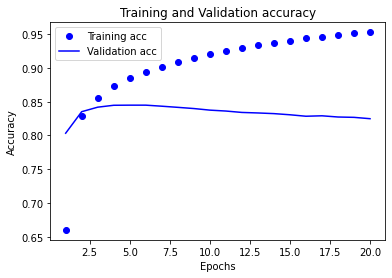

In [33]:
# Accuracy 그래프 시각화 

plt.clf() # 그림을 초기화 합니다.

plt.plot(epochs, gmp_acc, 'bo', label='Training acc')
plt.plot(epochs, gmp_val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 학습된 Embedding 레이어 분석

- embedding 파라미터 저장하기
- word vector 활용하기 - feat.gensim

(1) RNN_Model

In [34]:
# rnn_model
rnn_embedding_layer = rnn_model.layers[0]
rnn_weights = rnn_embedding_layer.get_weights()[0]
print(rnn_weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [35]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
rnn_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/rnn_word2vec.txt'
f = open(rnn_word2vec_file_path, 'w')
f.write('{} {}\n'.format(rnn_vocab_size-4, rnn_word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
rnn_vectors = rnn_model.get_weights()[0]
for i in range(4,rnn_vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(rnn_vectors[i, :])))))
f.close()

print('저장 완료!')

저장 완료!


In [36]:
# 임베딩 파라미터 활용하기 

rnn_word_vectors = Word2VecKeyedVectors.load_word2vec_format(rnn_word2vec_file_path, binary=False)
rnn_vector = rnn_word_vectors['대박'] # 영어가 없기 때문에 한글로 입력 해 줘야함! 
rnn_vector

array([-0.12039975, -0.1362806 ,  0.07715238, -0.1560532 , -0.09424632,
        0.17033173,  0.15905374,  0.11024861,  0.12284131,  0.04797401,
       -0.08129017,  0.1018856 ,  0.21895707,  0.08158004, -0.14582984,
       -0.06657912], dtype=float32)

In [37]:
# gensim 을 이용한 유사도 체크 
rnn_word_vectors.similar_by_word("대박")

[('여운', 0.9802860021591187),
 ('빠져들', 0.9799150824546814),
 ('감탄', 0.9788580536842346),
 ('이스트우드', 0.9773422479629517),
 ('극대', 0.9761981964111328),
 ('전하', 0.9750185012817383),
 ('할아버지', 0.9725496172904968),
 ('우산', 0.9698996543884277),
 ('따듯', 0.9692997932434082),
 ('레전드', 0.9692253470420837)]

(2) 1-D CNN 모델

In [39]:
# cnn1d_model
cnn1d_embedding_layer = cnn1d_model.layers[0]
cnn1d_weights = cnn1d_embedding_layer.get_weights()[0]
print(cnn1d_weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [40]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
cnn1d_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/cnn1d_word2vec.txt'
f = open(cnn1d_word2vec_file_path, 'w')
f.write('{} {}\n'.format(cnn1d_vocab_size-4, cnn1d_word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
cnn1d_vectors = cnn1d_model.get_weights()[0]
for i in range(4,cnn1d_vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(cnn1d_vectors[i, :])))))
f.close()

print('저장 완료!')

저장 완료!


In [41]:
# 임베딩 파라미터 활용하기 

cnn1d_word_vectors = Word2VecKeyedVectors.load_word2vec_format(cnn1d_word2vec_file_path, binary=False)
cnn1d_vector = cnn1d_word_vectors['대박'] # 영어가 없기 때문에 한글로 입력 해 줘야함! 
cnn1d_vector

array([ 0.18401888,  0.10327123,  0.05969993,  0.0354538 , -0.09100948,
       -0.22683112, -0.02234726, -0.04958392, -0.06639865, -0.14095755,
       -0.02733888,  0.0780144 , -0.15619403,  0.07331553,  0.05119095,
       -0.0726879 ], dtype=float32)

In [42]:
# gensim 을 이용한 유사도 체크 
cnn1d_word_vectors.similar_by_word("대박")

[('싹', 0.9236565828323364),
 ('들어온다', 0.8638429045677185),
 ('됬', 0.852950930595398),
 ('아름다웠', 0.8445135354995728),
 ('찾아본', 0.8412066102027893),
 ('공연', 0.8357948064804077),
 ('김효진', 0.8349258303642273),
 ('그럼에도', 0.8302578330039978),
 ('놀라움', 0.8272250890731812),
 ('무릎', 0.8250651359558105)]

(3) GlobalMaxPooling1D 모델

In [43]:
# gmp_model 

gmp_embedding_layer = gmp_model.layers[0]
gmp_weights = gmp_embedding_layer.get_weights()[0]
print(gmp_weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [44]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
gmp_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/gmp_word2vec.txt'
f = open(gmp_word2vec_file_path, 'w')
f.write('{} {}\n'.format(gmp_vocab_size-4, gmp_word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
gmp_vectors = gmp_model.get_weights()[0]
for i in range(4,gmp_vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(gmp_vectors[i, :])))))
f.close()

print('저장 완료!')

저장 완료!


In [45]:
# 임베딩 파라미터 활용하기 

gmp_word_vectors = Word2VecKeyedVectors.load_word2vec_format(gmp_word2vec_file_path, binary=False)
gmp_vector = gmp_word_vectors['대박'] # 영어가 없기 때문에 한글로 입력 해 줘야함! 
gmp_vector

array([ 0.09840953, -0.07779951,  0.02755256, -0.08213684, -0.00163701,
       -0.05993151, -0.03241406, -0.02525766,  0.14901993, -0.00973225,
       -0.06735375, -0.16394512, -0.22948864, -0.25243545,  0.1953625 ,
       -0.05983059], dtype=float32)

In [46]:
# gensim 을 이용한 유사도 체크 
gmp_word_vectors.similar_by_word("대박")

[('엠마', 0.818354606628418),
 ('민주주의', 0.7891456484794617),
 ('아주', 0.7863101363182068),
 ('저하', 0.7839410305023193),
 ('제니퍼', 0.7805615663528442),
 ('듭니다', 0.7778851985931396),
 ('볼까', 0.7773734331130981),
 ('찰', 0.7475219964981079),
 ('무방', 0.7449184656143188),
 ('살린', 0.7434089183807373)]

In [47]:
print()
print('RNN 모델의 경우')
print('-'*20)
rnn_word_vectors.similar_by_word("영화")


RNN 모델의 경우
--------------------


[('습니다', 0.929952085018158),
 ('!', 0.8539557456970215),
 ('ㅎ', 0.8370698094367981),
 ('!!!', 0.8217648863792419),
 ('어요', 0.8206010460853577),
 ('음', 0.8128665685653687),
 ('ㅎㅎ', 0.8069459795951843),
 ('준다', 0.8047982454299927),
 ('~~', 0.8014805912971497),
 ('요', 0.7921350002288818)]

In [48]:
print()
print('1-D CNN 모델의 경우 ')
print('-'*20)
cnn1d_word_vectors.similar_by_word("영화")


1-D CNN 모델의 경우 
--------------------


[('음', 0.8863928318023682),
 ('ever', 0.7730908989906311),
 ('봄', 0.7247803211212158),
 ('심은경', 0.7244694828987122),
 ('오래간만', 0.7122269868850708),
 ('뒷맛', 0.6831129789352417),
 ('껀', 0.6725044846534729),
 ('영원', 0.6666529774665833),
 ('아유', 0.6659013032913208),
 ('유해진', 0.6585859060287476)]

In [49]:
print()
print('-'*20)
print('GlobalMaxPooling1D 모델의 경우')
gmp_word_vectors.similar_by_word("영화")


--------------------
GlobalMaxPooling1D 모델의 경우


[('.', 0.9880279898643494),
 ('을', 0.9843899011611938),
 ('는데', 0.9795347452163696),
 ('너무', 0.9792666435241699),
 ('다', 0.9785040616989136),
 ('많이', 0.9775363802909851),
 ('고', 0.9759652614593506),
 ('이랑', 0.9755885004997253),
 ('하', 0.9665220975875854),
 ('메이', 0.9638712406158447)]

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

- 한국어 Word2Vec의 버전이, lms 노드의 버전과 달라 버전을 다운그레이드 해 줘야함
- 우선, 현재 gensim의 버전은 '4.1.2'

In [50]:
import gensim
gensim.__version__ 

'3.8.3'

In [51]:
!pip install gensim  
!pip install --upgrade gensim==3.8.3 #[버전 다운그레이드 하는 코드]

In [52]:
!pip list | grep gensim

gensim                        3.8.3


In [53]:
gensim.__version__ 

'3.8.3'

In [54]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

In [56]:
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [57]:
vector = word2vec['한글']
vector 

/tmp/ipykernel_389/2012081322.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['한글']


array([ 1.6128085 , -1.1544337 , -0.5932879 ,  1.0139976 ,  0.14398324,
        0.06146022, -1.2307618 ,  1.246725  , -0.36126938, -0.58117795,
       -1.7926406 ,  1.1809887 ,  0.09327681, -2.1807477 , -0.61531913,
        0.8726902 , -1.0970036 ,  1.3963151 ,  1.0671253 , -1.8440446 ,
        0.8027888 ,  0.29326743, -0.9776343 , -0.2296304 ,  1.3892593 ,
        0.6026744 , -1.0210171 , -1.1725664 ,  0.6729586 , -0.23679246,
        0.8755139 ,  1.3650341 ,  0.55645025,  0.09423062, -1.202211  ,
        0.17125276,  0.68014663,  2.7045243 ,  2.2534132 , -0.40493518,
        0.1276657 , -2.671103  ,  2.6819725 , -0.7603048 , -2.144086  ,
        2.8544457 , -0.33210874, -1.9362477 , -0.77313316, -0.7834715 ,
        1.4361358 , -1.2351226 ,  0.07767043, -0.15594688,  0.12987676,
       -0.0743077 , -0.24870954, -1.8310938 , -0.98321086, -1.469205  ,
        0.5321793 , -1.3140066 , -1.1456997 ,  2.8354068 ,  0.19710186,
        0.63099426,  1.2202299 , -1.2086796 , -0.85067475,  0.75

In [58]:
# 제시한 단어와 연관 단어를 찾아볼까나
word2vec.similar_by_word("밥")

/tmp/ipykernel_389/2903394802.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("밥")


[('스폰지', 0.6359171867370605),
 ('반찬', 0.6288836002349854),
 ('떡', 0.6208181381225586),
 ('계란', 0.6053064465522766),
 ('시럽', 0.6036492586135864),
 ('초콜릿', 0.6027452349662781),
 ('푸딩', 0.5942443609237671),
 ('국물', 0.5894560813903809),
 ('치킨', 0.589329719543457),
 ('비스킷', 0.5666051506996155)]

In [59]:
# 제시한 단어와 연관 단어를 찾아볼까나
word2vec.similar_by_word("영화")

/tmp/ipykernel_389/695650924.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("영화")


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

유사도 체크 결과 보다 훨씬 유사한 단어, 연관있는 단어를 찾음

### 모델의 enbedding layer 교체하기

In [60]:
#임베딩 레이어 교체 
vocab_size = 10000
word_vector_dim = 200 #워드 벡터의 차원 수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

print('워드 벡터 카피 완료!')

워드 벡터 카피 완료!


/tmp/ipykernel_389/2322596148.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_389/2322596148.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


## 학습진행

In [61]:
# 파라미터 설정 

epochs = 10
dense = 64

In [63]:
from tensorflow.keras.layers import Dropout, Dense

# RNN 모델 
# padding_where = 'pre'

rn2_model = tf.keras.Sequential()
rn2_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix), 
                                        input_length=maxlen, trainable=True))



# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다.
rn2_model.add(tf.keras.layers.LSTM(128))   
rn2_model.add(Dropout(0.5))
rn2_model.add(tf.keras.layers.Dense(dense, activation='relu'))
rn2_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rn2_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 2,176,769
Trainable params: 2,176,769
Non-trainable params: 0
_________________________________________________________________


In [66]:

rn2_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=epochs  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

rn2_history = rn2_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
1517/1517 [==============================] - 12s 7ms/step - loss: 0.4211 - accuracy: 0.8036 - val_loss: 0.3469 - val_accuracy: 0.8440
Epoch 2/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.3134 - accuracy: 0.8663 - val_loss: 0.3216 - val_accuracy: 0.8610
Epoch 3/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.2704 - accuracy: 0.8881 - val_loss: 0.3161 - val_accuracy: 0.8636
Epoch 4/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.2383 - accuracy: 0.9018 - val_loss: 0.3279 - val_accuracy: 0.8647
Epoch 5/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.2070 - accuracy: 0.9160 - val_loss: 0.3386 - val_accuracy: 0.8651
Epoch 6/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.1789 - accuracy: 0.9291 - val_loss: 0.3751 - val_accuracy: 0.8641
Epoch 7/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.1525 - accuracy: 0.9406 - val_loss: 0.3845 - val_ac

In [67]:
# 평가하기 

print('-'*20)
print()
rn2_results = rn2_model.evaluate(X_test, y_test, verbose=2)
print('RNN 모델 결과 :', rn2_results)
print()

--------------------

1537/1537 - 3s - loss: 0.4823 - accuracy: 0.8544
RNN 모델 결과 : [0.482281893491745, 0.8544256091117859]



In [68]:
# 1-D CNN 모델
# 패딩 위치 
padding_where = 'post'

cn2_model = tf.keras.Sequential()
cn2_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix),# 임베딜 적용 
                                        input_length=maxlen,
                                        trainable=True))
cn2_model.add(tf.keras.layers.Conv1D(32, 7, activation='relu')) 
cn2_model.add(tf.keras.layers.MaxPooling1D(5))
cn2_model.add(Dropout(0.5))
cn2_model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
cn2_model.add(Dropout(0.5))
cn2_model.add(tf.keras.layers.GlobalMaxPooling1D())
cn2_model.add(tf.keras.layers.Dense(dense, activation='relu'))
cn2_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cn2_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 32)            44832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 32)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 32)             7200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)               

In [69]:
# 모델 학습 및 예측 

cn2_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=epochs  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

cn2_history = cn2_model.fit(partial_X_train, partial_y_train,
                            epochs=epochs,batch_size=32,validation_data=(X_val, y_val),verbose=1)

Epoch 1/10
3033/3033 [==============================] - 18s 6ms/step - loss: 0.5744 - accuracy: 0.6785 - val_loss: 0.4226 - val_accuracy: 0.8234
Epoch 2/10
3033/3033 [==============================] - 17s 6ms/step - loss: 0.4053 - accuracy: 0.8186 - val_loss: 0.3957 - val_accuracy: 0.8452
Epoch 3/10
3033/3033 [==============================] - 17s 6ms/step - loss: 0.3606 - accuracy: 0.8449 - val_loss: 0.3649 - val_accuracy: 0.8490
Epoch 4/10
3033/3033 [==============================] - 19s 6ms/step - loss: 0.3343 - accuracy: 0.8577 - val_loss: 0.3655 - val_accuracy: 0.8539
Epoch 5/10
3033/3033 [==============================] - 17s 6ms/step - loss: 0.3163 - accuracy: 0.8669 - val_loss: 0.3482 - val_accuracy: 0.8547
Epoch 6/10
3033/3033 [==============================] - 17s 6ms/step - loss: 0.3002 - accuracy: 0.8749 - val_loss: 0.3455 - val_accuracy: 0.8515
Epoch 7/10
3033/3033 [==============================] - 17s 6ms/step - loss: 0.2877 - accuracy: 0.8793 - val_loss: 0.3399 - val_ac

In [70]:
# 평가하기 

print('-'*20)
print()
cn2_results = cn2_model.evaluate(X_test, y_test, verbose=2)
print('1-D CNN 모델 결과 : ', cn2_results)
print()

--------------------

1537/1537 - 3s - loss: 0.3483 - accuracy: 0.8498
1-D CNN 모델 결과 :  [0.3483198583126068, 0.8498281240463257]



In [71]:
# GlobalMaxPooling1D 모델

padding_where = 'post'

gp2_model = tf.keras.Sequential()
gp2_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix), 
                                        input_length=maxlen, trainable=True))
gp2_model.add(Dropout(0.5))
gp2_model.add(tf.keras.layers.GlobalMaxPooling1D())
gp2_model.add(tf.keras.layers.Dense(dense, activation='relu'))
gp2_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gp2_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 41, 200)           0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 2,012,929
Trainable params: 2,012,929
Non-trainable params: 0
_________________________________________________________________


In [72]:
# 모델 학습 
gp2_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=epochs  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

gp2_history = gp2_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.6261 - accuracy: 0.6536 - val_loss: 0.5552 - val_accuracy: 0.7345
Epoch 2/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.5293 - accuracy: 0.7357 - val_loss: 0.5039 - val_accuracy: 0.7715
Epoch 3/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.4804 - accuracy: 0.7686 - val_loss: 0.4880 - val_accuracy: 0.7676
Epoch 4/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.4470 - accuracy: 0.7903 - val_loss: 0.4469 - val_accuracy: 0.8118
Epoch 5/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.4241 - accuracy: 0.8046 - val_loss: 0.4362 - val_accuracy: 0.8194
Epoch 6/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.4080 - accuracy: 0.8126 - val_loss: 0.4196 - val_accuracy: 0.8258
Epoch 7/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.3944 - accuracy: 0.8214 - val_loss: 0.4088 - val_accuracy:

In [73]:
# 평가하기 

print('-'*20)
print()
gp2_results = gp2_model.evaluate(X_test, y_test, verbose=2)
print('GlobalMaxPooling1D 모델 결과 :', gp2_results)
print()

--------------------

1537/1537 - 2s - loss: 0.3609 - accuracy: 0.8423
GlobalMaxPooling1D 모델 결과 : [0.3608914315700531, 0.8423418998718262]



In [75]:
from pandas import DataFrame as df 

compare = df(data = {'모델명':['RNN', '1-D CNN', 'GlobalMaxPooling'],
                    '임베딩 적용전':['0.8274', '0.8171', '0.8192'],
                    '임베딩 적용후':['0.8520', '0.8501', '0.8448']})
compare

,모델명,임베딩 적용전,임베딩 적용후
0,RNN,0.8274,0.8520
1,1-D CNN,0.8171,0.8501
2,GlobalMaxPooling,0.8192,0.8448


In [76]:
rn2_model.save("EXP6_kr_rn2.h5")
cn2_model.save("EXP6_kr_cn2.h5")
gp2_model.save("EXP6_kr_gp2.h5")

# Report

일반 텍스트등을 분석하기 위해서는 본 프로젝트처럼, 텍스트 데이터를 딕셔너리로 무엇을 기준으로 나눌 것인지 분류를 하는 작업이 필요하였으며
그 후, 인덱싱하여 반환시키고 벡터와 짝짓기위하여 embedding레이어를 활용하는 과정이 필요했음.

임베딩하는 단계에 넣기 위해서 데이터를 일정한 간격으로 맞추는 작업이 필요했고, 본 데이터들은 시퀀스 데이터로서 RNN, CNN,단독 Globalmax pooling 을 적용한 세가지 모델들을 적용을 함으로써 텍스트를 처리할 수가 있었음.

초기데이터들을 시각화시켰을 때, 3가지의 모델과 Validation set을 다 같이 적용 함에도 train set과의 validation loss가 차이가 컸음.

이에, Word2Vec모델을 새롭게 적용하였으며, 앞의 모델의 처리 기억들을 반영하기 위해서 가중치를 부여하여 훈련 시킴.

그럼으로써 RNN model 및 CNN model에서 accuracy가 85% 이상이 되었음을 확인함.